<a href="https://colab.research.google.com/github/DevDae/ML_Project/blob/main/catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [ ]:
plt.rc('font', family='NanumBarunGothic')

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/결측치완료.csv',encoding='cp949')

In [ ]:
df = data.copy()

In [ ]:
#범주형 변수 삭제
#물리적 들어가는거 전부 0, 배타적, 직원총수 부정확한 데이터
df = df.drop(['시설명', '소재지', '지류', '중심처리시설', '명칭', '적용신기술', '처리방법', '구군' ,'물리적', '물리적 유입하수량', '물리적 방류량',  ], axis=1)

In [ ]:
#처리효율이 0인 값들은 유입 방류되는 값이 존재하지 않음
deleteIndex = df[df['처리효율']== 0].index
df = df.drop(deleteIndex)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
#정규화하기 위해 분리, 나중에 concat 예정
dataX_con = df.drop([ '방류수 소독방법','목표수질(BOD)', '시도', '운영주체', '지역구분', '세부단위 구역', '수계','처리효율' ], axis=1)
dataX_cat = df[['방류수 소독방법','목표수질(BOD)', '시도', '운영주체', '지역구분', '세부단위 구역', '수계']]

In [ ]:
#나중에 열이름 다시 붙여줘야함
dataColumn = dataX_con.columns

In [ ]:
dataY = pd.DataFrame(df['처리효율'])

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
dataX_con = scaler.fit_transform(dataX_con)

In [ ]:
dataX_con = pd.DataFrame(dataX_con,columns = dataColumn)

In [ ]:
#인덱스 초기화 및 재설정
dataX_cat.reset_index(drop=True, inplace = True)

In [ ]:
dataX = pd.concat([dataX_cat,dataX_con],axis=1)

# **타겟변수 변환**

In [ ]:
print('Skewness: {:05.2f}'.format(dataY['처리효율'].skew()) ,  '   ' ,  'Kurtosis: {:06.2f}'.format(dataY['처리효율'].kurt())  )

Skewness: -10.63     Kurtosis: 132.50


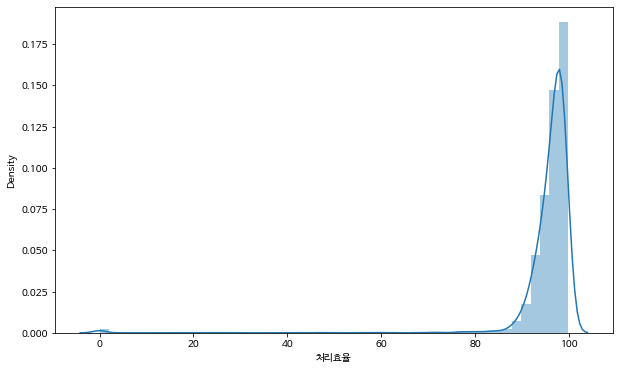

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

f, ax = plt.subplots(figsize = (10, 6))

sns.distplot(dataY['처리효율'])

Skewness: -14.507
Kurtosis: 212.032


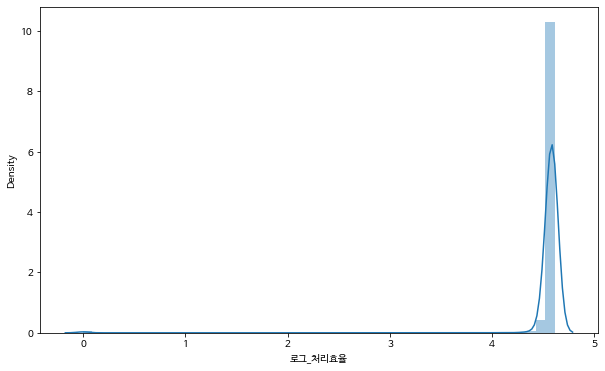

In [ ]:
#처리효율에 대해 로그화
dataY['로그_처리효율'] = np.log1p(dataY['처리효율'])

f, ax = plt.subplots(figsize = (10, 6))

sns.distplot(dataY['로그_처리효율'])

print("Skewness: {:.3f}".format(dataY['로그_처리효율'].skew()))
print("Kurtosis: {:.3f}".format(dataY['로그_처리효율'].kurt()))


Skewness: -13.305
Kurtosis: 186.721


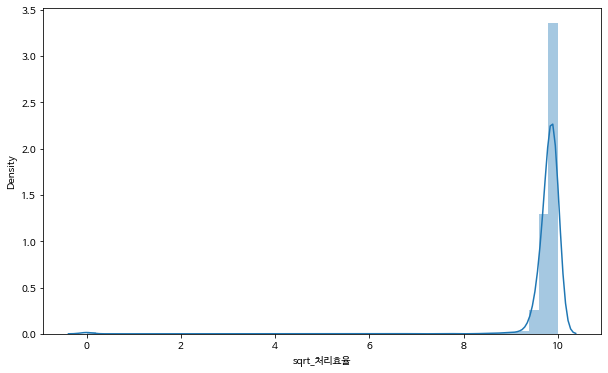

In [ ]:
#처리효율에 대해 로그화
dataY['sqrt_처리효율'] = np.sqrt(dataY['처리효율'])

f, ax = plt.subplots(figsize = (10, 6))

sns.distplot(dataY['sqrt_처리효율'])

print("Skewness: {:.3f}".format(dataY['sqrt_처리효율'].skew()))
print("Kurtosis: {:.3f}".format(dataY['sqrt_처리효율'].kurt()))


Text(0.5, 1.0, 'Probplot for sqrt_처리효율')

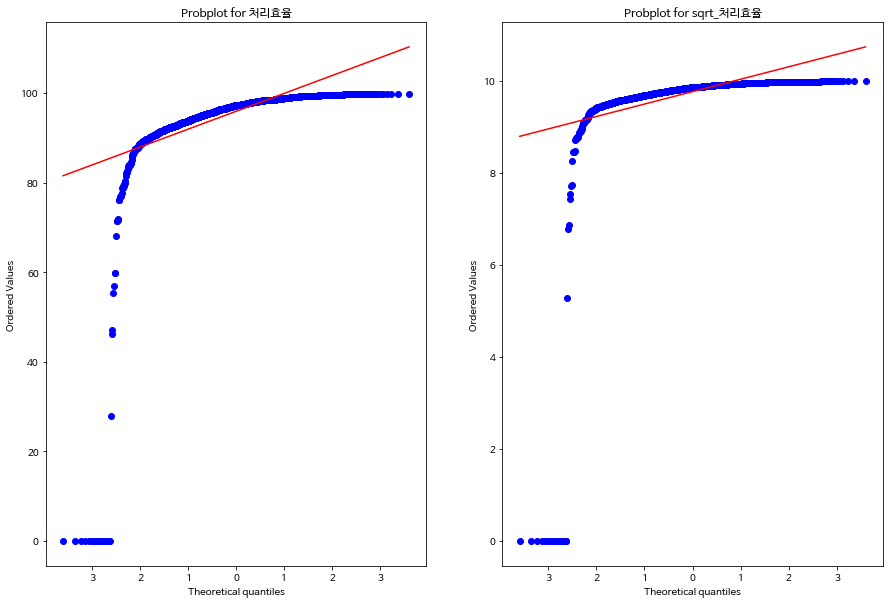

In [ ]:
#처리효율과 sqrt처리효율 비교 
#비슷함
from scipy import stats

fig = plt.figure(figsize = (15,10))

ax1 = fig.add_subplot(1,2,1)
res = stats.probplot(dataY['처리효율'], plot=plt)

ax2 = fig.add_subplot(1,2,2)
res = stats.probplot(dataY['sqrt_처리효율'], plot=plt)

ax1.set_title("Probplot for 처리효율")
ax2.set_title("Probplot for sqrt_처리효율")


Text(0.5, 1.0, 'Probplot for 로그_처리효율')

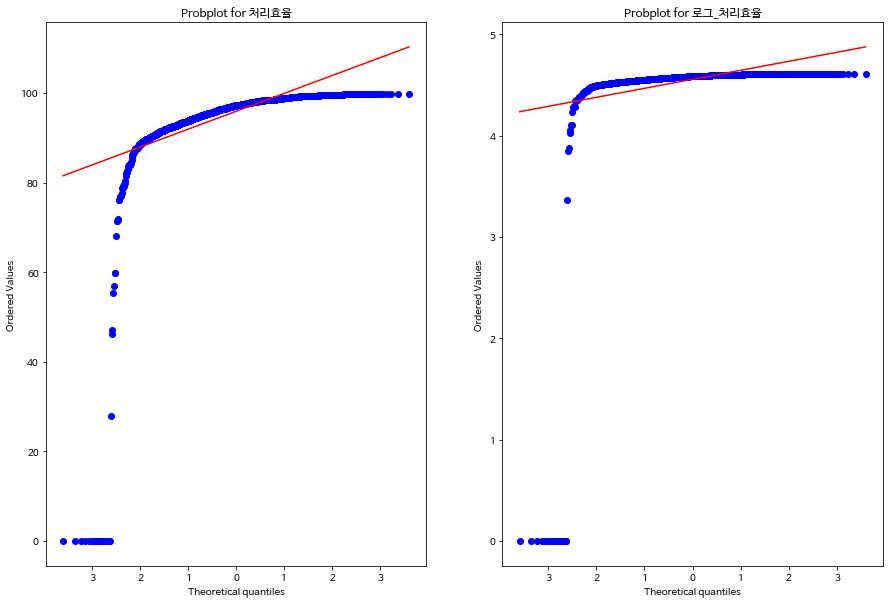

In [ ]:
#처리효율과 로그처리효율 비교
#비슷함
from scipy import stats

fig = plt.figure(figsize = (15,10))

ax1 = fig.add_subplot(1,2,1)
res = stats.probplot(dataY['처리효율'], plot=plt)

ax2 = fig.add_subplot(1,2,2)
res = stats.probplot(dataY['로그_처리효율'], plot=plt)
ax1.set_title("Probplot for 처리효율")
ax2.set_title("Probplot for 로그_처리효율")


In [ ]:
#모델 돌릴 변수만 남기고 나머지 지우기
dataY = dataY.drop(['로그_처리효율', 'sqrt_처리효율'], axis=1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(dataX, dataY, train_size=0.7, test_size=0.3, random_state=2022)

# **CatBoost**

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [ ]:
from catboost import CatBoostRegressor, Pool

In [ ]:
cb = CatBoostRegressor(n_estimators=200,
                       loss_function='RMSE',
                       learning_rate=0.3,
                       depth=5, task_type='CPU',
                       random_state=2022,
                       verbose=False)

In [ ]:
pool_train = Pool(x_train, y_train,
                  cat_features = ['방류수 소독방법','목표수질(BOD)', '시도', '운영주체', '지역구분', '세부단위 구역', '수계'])

In [ ]:
pool_test = Pool(x_test, cat_features = ['방류수 소독방법','목표수질(BOD)', '시도', '운영주체', '지역구분', '세부단위 구역', '수계'])

In [ ]:
cb.fit(pool_train)
y_pred = cb.predict(pool_test)

In [ ]:
from sklearn.metrics import mean_squared_error as mse

In [ ]:
cb_rmse = np.sqrt(mse(y_test, y_pred))
print("RMSE in y units:", np.mean(cb_rmse))

RMSE in y units: 1.7741868076529321


In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.7600856768585522

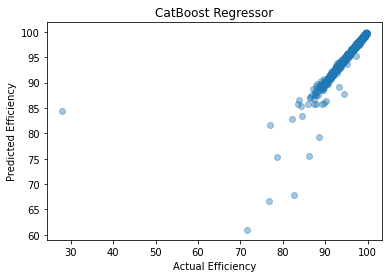

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred, alpha=0.4)
plt.xlabel("Actual Efficiency")
plt.ylabel("Predicted Efficiency")

plt.title("CatBoost Regressor")
plt.show()

In [ ]:
#no free lunch theorem